In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = sns.load_dataset('mpg')

In [5]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [9]:
data = data.dropna()

In [11]:
#Split dataset into training set and test set
X = data.drop('mpg', axis=1)
y = data['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
#Basic linear regression with one independent variable
X1 = X_train[['horsepower']]
lin_mod = LinearRegression().fit(X1.values, y_train)
#Calculate mean squared error for linear model
lin_mod_mse = mean_squared_error(y_train, lin_mod.predict(X1))
print(lin_mod_mse)

24.456861668149127


In [15]:
#Linear model score
lin_mod.score(X1, y_train) * 100

59.07824029983285

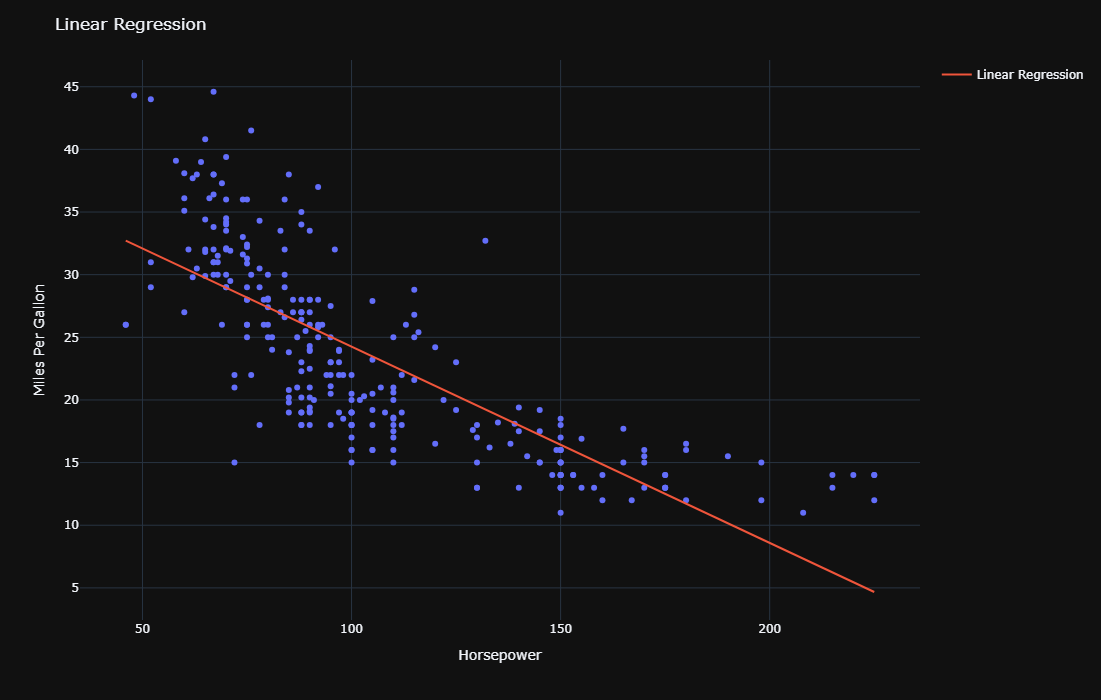

In [49]:
#Create scatterplot with linear regression
x_range = np.linspace(X1.min(), X1.max(), 100).reshape(-1, 1)
y_range = lin_mod.predict(x_range.reshape(-1,1))

fig = go.Figure(px.scatter(x=X_train['horsepower'], y=y_train))
fig.add_trace(go.Scatter(x=x_range.squeeze(), y=y_range, name='Linear Regression'))

#Formatting
fig.update_layout(
    title=dict(text='Linear Regression'),
    xaxis=dict(title=dict(text='Horsepower')),
    yaxis=dict(title=dict(text='Miles Per Gallon'))
)
fig.update_layout(width=1000, height=700)
fig.update_layout(template='plotly_dark')

fig.show()

19.186966499482796
67.89594498587958


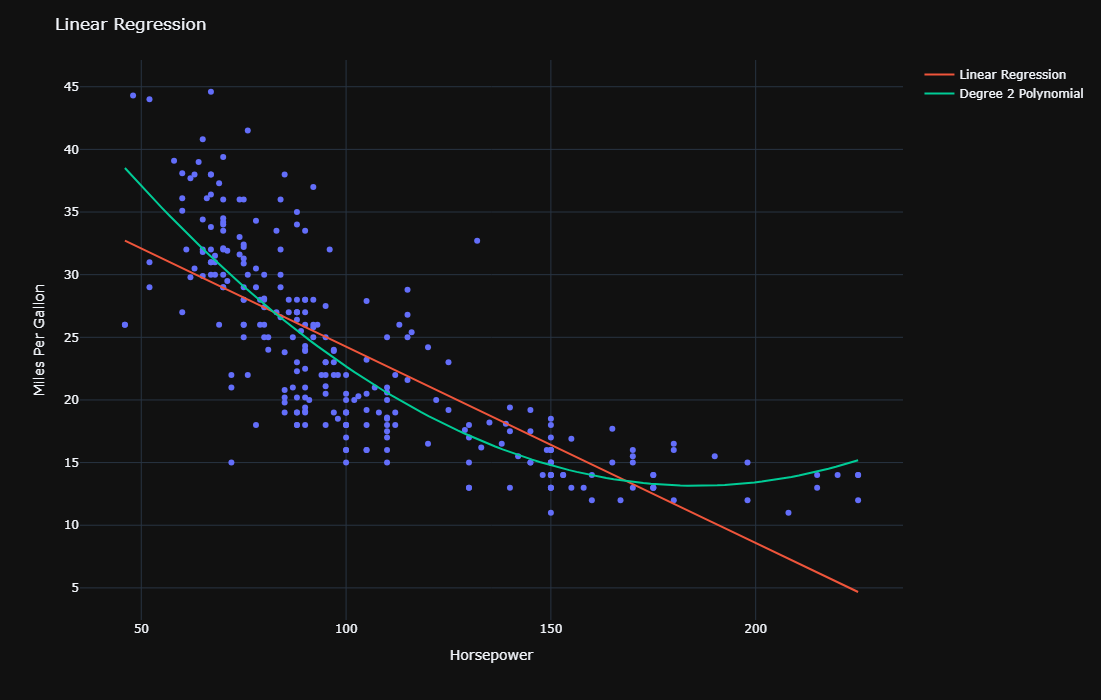

In [51]:
#Degree 2 polynomial using linear regression model
#Pipeline to create polynomial features first, then perform a linear regression
pipe = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),
    ('lin_reg', LinearRegression())
])
pipe.fit(X1, y_train)
print(mean_squared_error(y_train, pipe.predict(X1)))
print(pipe.score(X1, y_train) * 100)

#Add degree 2 linear regression to trace
y_pipe = pipe.predict(x_range.reshape(-1,1))
fig.add_trace(go.Scatter(x=x_range.squeeze(), y=y_pipe, name = 'Degree 2 Polynomial'))
fig.update_layout(template='plotly_dark')
fig.show()

In [53]:
#Create dataframe of predictions for degree 1-6 linear regressions
model_predictions = {f'degree_{i}': None for i in range(1, 6)}

for i in range(1,6):
    pipe2 = Pipeline([
        ('poly_features', PolynomialFeatures(degree=i)),
        ('lin_reg', LinearRegression())
    ])
    pipe2.fit(X1, y_train)
    preds = pipe2.predict(X1)
    model_predictions[f'degree_{i}'] = preds

pred_df = pd.DataFrame(model_predictions)
pred_df

,degree_1,degree_2,degree_3,degree_4,degree_5
0,18.769791,16.468161,16.639148,16.086037,16.513865
1,28.952418,30.534504,30.609098,30.856179,31.519539
2,24.252744,22.672363,22.399808,22.281049,21.650977
3,27.542516,27.929265,27.786865,28.113463,28.438449
4,24.252744,22.672363,22.399808,22.281049,21.650977
...,...,...,...,...,...
269,25.036023,23.819627,23.538298,23.560331,23.066021
270,27.229204,27.379027,27.203215,27.515262,27.729750
271,22.686186,20.573548,20.374489,19.991860,19.357378
272,23.469465,21.590337,21.346205,21.088893,20.411806


In [55]:
error_df = pred_df.subtract(y, axis=0)
variance_errors = error_df.var()
variance_errors

degree_1    79.812297
degree_2    82.437041
degree_3    82.539249
degree_4    82.827249
degree_5    82.790641
dtype: float64

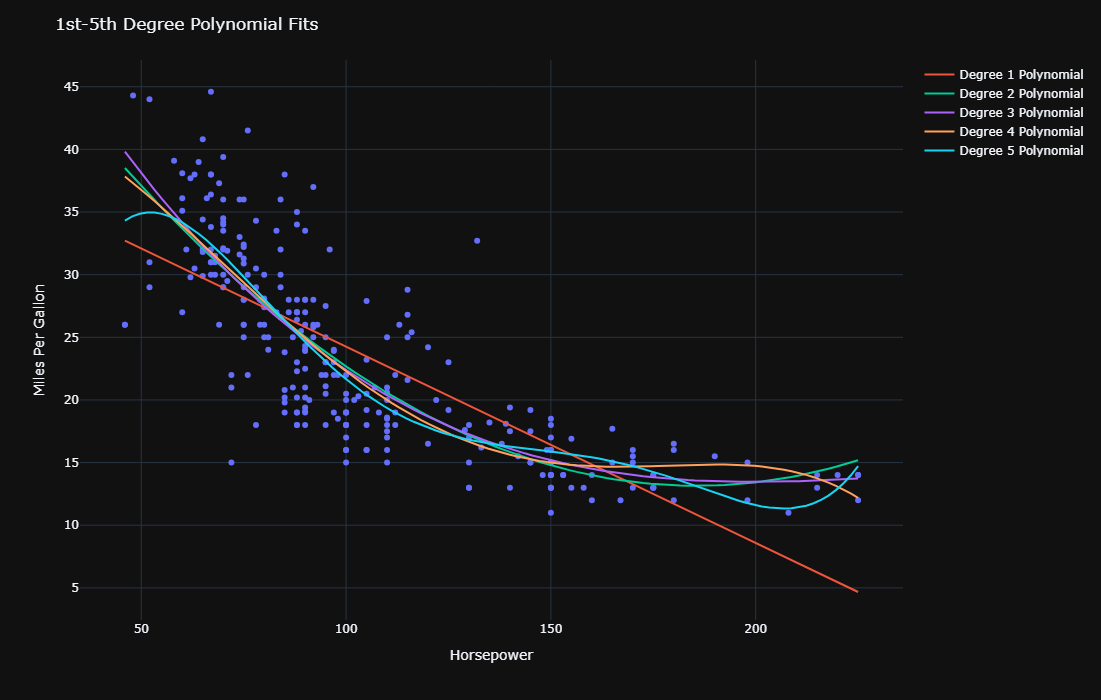

In [57]:
#Create new figure of training data to keep things clean
fig2 = go.Figure(px.scatter(x=X_train['horsepower'], y=y_train))

#Add traces for degree 1-6 linear regressions
x_range2 = np.linspace(X1.min(), X1.max(), 100).reshape(-1, 1)

for i in range(1,6):
    pipe3 = Pipeline([
        ('poly_features', PolynomialFeatures(degree=i)),
        ('lin_reg', LinearRegression())
    ])
    pipe3.fit(X1.values, y_train)
    y_pipe3 = pipe3.predict(x_range2.reshape(-1,1))
    fig2.add_trace(go.Scatter(x=x_range2.squeeze(), y=y_pipe3, name = f'Degree {i} Polynomial'))

#Formatting
fig2.update_layout(
    title=dict(text='1st-5th Degree Polynomial Fits'),
    xaxis=dict(title=dict(text='Horsepower')),
    yaxis=dict(title=dict(text='Miles Per Gallon'))
)
fig2.update_layout(width=1000, height=700)
fig2.update_layout(template='plotly_dark')

fig2.show()

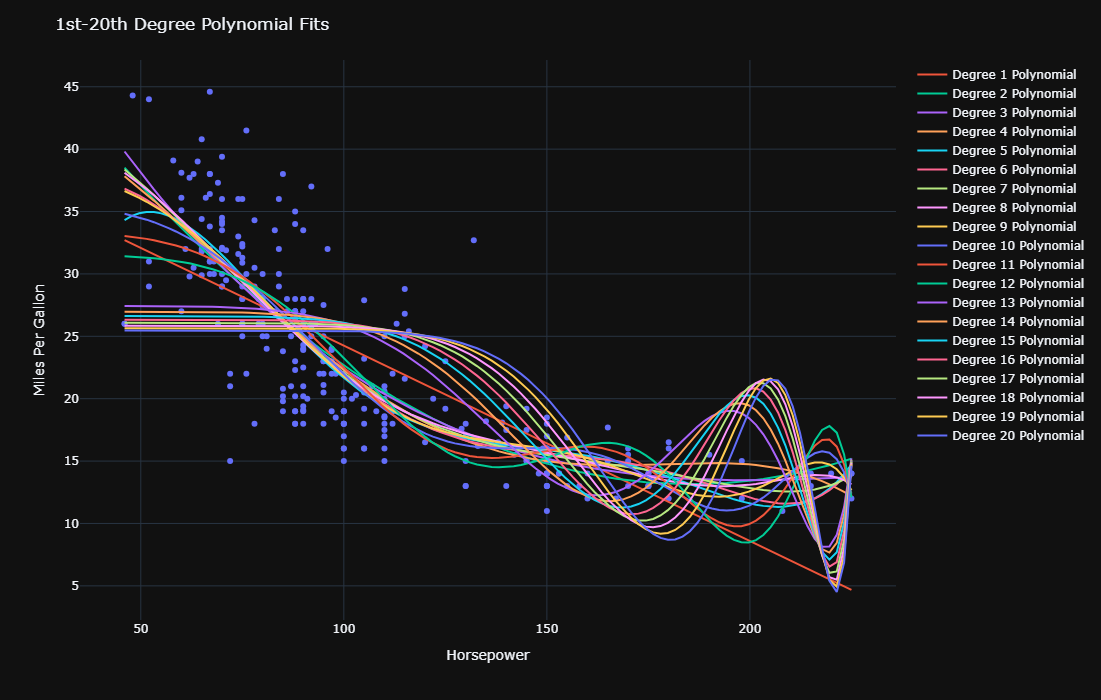

In [59]:
#Create new figure of training data to keep things clean. Demonstrating overfitting
fig3 = go.Figure(px.scatter(x=X_train['horsepower'], y=y_train))

#Add traces for degree 1-6 linear regressions
x_range2 = np.linspace(X1.min(), X1.max(), 100).reshape(-1, 1)

for i in range(1,21):
    pipe3 = Pipeline([
        ('poly_features', PolynomialFeatures(degree=i)),
        ('lin_reg', LinearRegression())
    ])
    pipe3.fit(X1.values, y_train)
    y_pipe3 = pipe3.predict(x_range2.reshape(-1,1))
    fig3.add_trace(go.Scatter(x=x_range2.squeeze(), y=y_pipe3, name = f'Degree {i} Polynomial'))

#Formatting
fig3.update_layout(
    title=dict(text='1st-20th Degree Polynomial Fits'),
    xaxis=dict(title=dict(text='Horsepower')),
    yaxis=dict(title=dict(text='Miles Per Gallon'))
)
fig3.update_layout(width=1000, height=700)
fig3.update_layout(template='plotly_dark')

fig3.show()

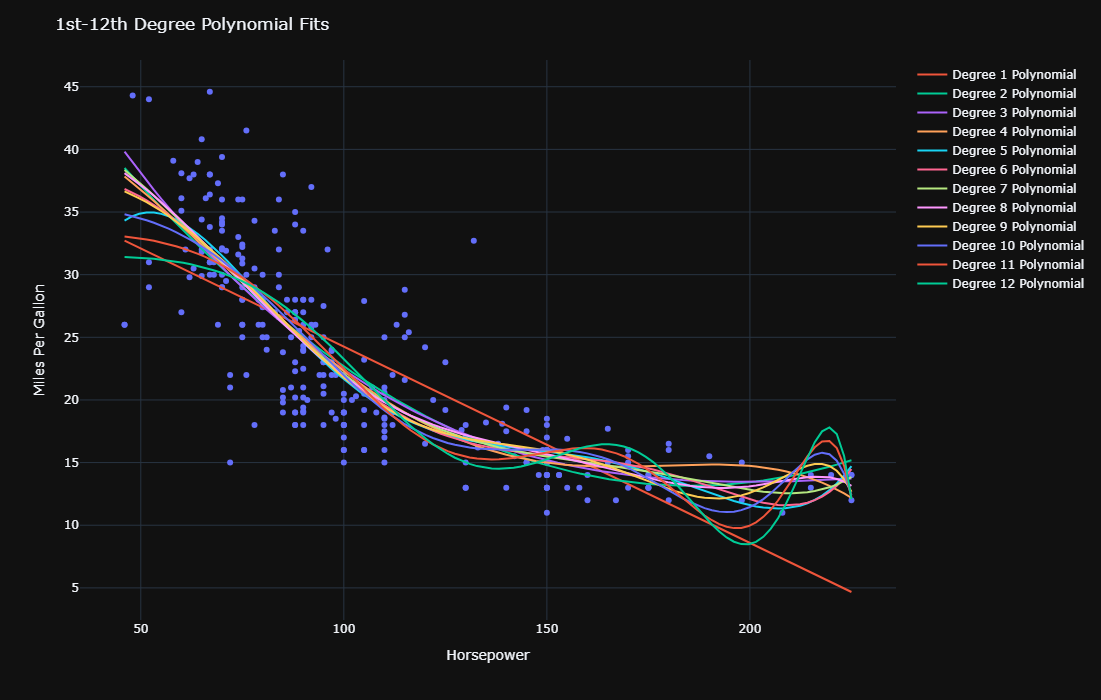

In [61]:
#Create new figure of training data to keep things clean. Demonstrating overfitting
fig3 = go.Figure(px.scatter(x=X_train['horsepower'], y=y_train))

#Add traces for degree 1-6 linear regressions
x_range2 = np.linspace(X1.min(), X1.max(), 100).reshape(-1, 1)

for i in range(1,13):
    pipe3 = Pipeline([
        ('poly_features', PolynomialFeatures(degree=i)),
        ('lin_reg', LinearRegression())
    ])
    pipe3.fit(X1.values, y_train)
    y_pipe3 = pipe3.predict(x_range2.reshape(-1,1))
    fig3.add_trace(go.Scatter(x=x_range2.squeeze(), y=y_pipe3, name = f'Degree {i} Polynomial'))

#Formatting
fig3.update_layout(
    title=dict(text='1st-12th Degree Polynomial Fits'),
    xaxis=dict(title=dict(text='Horsepower')),
    yaxis=dict(title=dict(text='Miles Per Gallon'))
)
fig3.update_layout(width=1000, height=700)
fig3.update_layout(template='plotly_dark')

fig3.show()